In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import json
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.tensorboard.writer import SummaryWriter

from sklearn.model_selection import train_test_split

from common import data
from common.training import training_loop

from algos import cbl

from common.models import resnet, deeplab
from common import metrics

In [4]:
paths = data.get_dataset_paths("../data")
train, test = train_test_split(paths, test_size=0.1, random_state=42)


In [5]:
# m_data_train = data.Marconi100Dataset(train, scaling=data.Scaling.STANDARD)
m_data_test = data.Marconi100Dataset(test, scaling=data.Scaling.STANDARD)


Loading: 100%|██████████| 25/25 [00:13<00:00,  1.83it/s]


In [6]:
horizon = 1024
stride = 512

batch_size = 32

log_dir = "./outputs/cbl"
lr = 1e-3
num_epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cpu


In [7]:
# dataset_train = data.UnfoldedDataset(m_data_train, horizon=horizon, stride=stride)
dataset_test = data.UnfoldedDataset(m_data_test, horizon=horizon, stride=stride)

In [8]:
# train_loader = DataLoader(
#     dataset_train,
#     batch_size,
#     shuffle=True,
# )
test_loader = DataLoader(
    dataset_test,
    batch_size // 4,
    shuffle=False,
)

In [9]:
batch = next(iter(test_loader))

In [10]:
bdata: torch.Tensor = batch["data"]
label: torch.Tensor = batch["label"]

In [42]:
pipe = cbl.pipeline(
    cbl.random(cbl.left_to_right_flipping(1), 0.9),
    cbl.crop_and_resize(2)
)

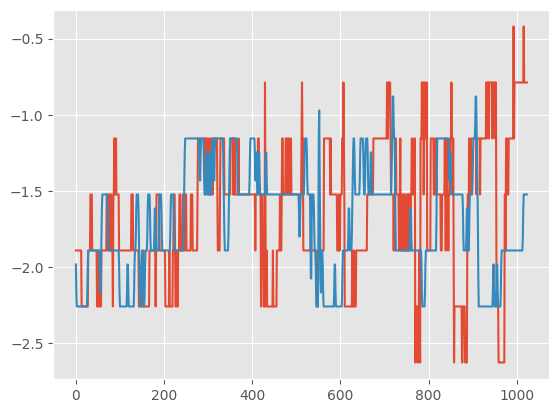

In [43]:
plt.plot(bdata[0, :, 10])
plt.plot(pipe(bdata)[0, :, 10])
plt.show()

In [54]:
model = resnet.ResNetFeatures(
    resnet.Bottleneck,
    resnet.RESNET50_LAYERS,
    data.NUM_FEATURES   
)

def forward(x: torch.Tensor):
    print(x.size())
    x = x.permute(0, 2, 1)
    print(x.size())
    x = model(x)[model.nodes[-1]]
    print(x.size())
    x = x.permute(0, 2, 1)
    print(x.size())
    return x

loss = cbl.SimContrastiveLoss(0.5)

In [56]:
feats = forward(bdata)

l = loss(feats)

torch.Size([8, 1024, 460])
torch.Size([8, 460, 1024])
torch.Size([8, 2048, 64])
torch.Size([8, 64, 2048])


RuntimeError: The size of tensor a (64) must match the size of tensor b (8) at non-singleton dimension 2